## STOCK PREDICTION MODEL = *TOMORROW UP OR DOWN*

-  Stock used en the model = Ecopetrol (EC)
-  Direct Variable used in the model =  WTI CRUDE (CL=F)

In [1]:
import sys
print("Ambiente activo:", sys.executable)

Ambiente activo: /opt/anaconda3/envs/midterm-model/bin/python


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os


In [3]:
# PRUEBA ESTO PRIMERO
df_test = pd.read_csv('data/EC_historical.csv')
print("Columnas reales en el CSV:")
print(df_test.columns.tolist())

Columnas reales en el CSV:
['Date', 'EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume']


In [4]:

print("Cargando datos desde CSV...")

# --- ECOPETROL ---
print("Cargando ECOPETROL (EC)...")
df_ec = pd.read_csv('data/EC_historical.csv', parse_dates=['Date'])
df_ec.set_index('Date', inplace=True)

# ¡YA TIENE LAS COLUMNAS CORRECTAS! → NO TOCAR
print(f"EC cargado: {len(df_ec)} filas")
print("Columnas EC:", df_ec.columns.tolist())

# --- WTI ---
print("Cargando WTI (CL=F)...")
df_wti = pd.read_csv('data/WTI_historical.csv', parse_dates=['Date'])
df_wti.set_index('Date', inplace=True)

# ¡TAMBIÉN DEBE TENER COLUMNAS RENOMBRADAS!
print(f"WTI cargado: {len(df_wti)} filas")
print("Columnas WTI:", df_wti.columns.tolist())

# --- UNIR DATOS ---
df = df_ec.join(df_wti[['WTI_Close']], how='inner')
print(f"Dataset final: {len(df)} filas")

Cargando datos desde CSV...
Cargando ECOPETROL (EC)...
EC cargado: 2515 filas
Columnas EC: ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume']
Cargando WTI (CL=F)...
WTI cargado: 2515 filas
Columnas WTI: ['WTI_Open', 'WTI_High', 'WTI_Low', 'WTI_Close', 'WTI_Volume']
Dataset final: 2513 filas


In [5]:
#ALINEAR OIL-WTI
df['WTI_Close'] = df_wti['WTI_Close'].reindex(df.index).ffill()

In [6]:
#CREAR FEATURES
df['WTI_Change'] = df['WTI_Close'].pct_change()
df['EC_WTI_Ratio'] = df['EC_Close'] / (df['WTI_Close'] + 1e-8)
df['WTI_Volatility'] = df['WTI_Close'].rolling(14).std()

print("\nFeatures de WTI creadas correctamente.")
print(df[['EC_Close', 'WTI_Close', 'EC_WTI_Ratio']].head(3))


Features de WTI creadas correctamente.
            EC_Close  WTI_Close  EC_WTI_Ratio
Date                                         
2015-11-09      9.56  43.869999      0.217917
2015-11-10      9.49  44.209999      0.214657
2015-11-11      9.21  42.930000      0.214535


In [7]:
#RENOMBRAR PARA ML
df['Close'] = df['EC_Close']  # Para mantener compatibilidad con tu código
df['Volume'] = df['EC_Volume']

#FEATURES TÉCNICAS (SMA, RSI, etc.)
df['SMA_100'] = df['Close'].rolling(100).mean()

In [8]:
# DEFINICION SW LA FUNCION PARA CALCULAR EL RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'])

#NUEVAS FEATURES TÉCNICAS
df['Overbought'] = (df['RSI_14'] > 70).astype(int)
df['Oversold'] = (df['RSI_14'] < 30).astype(int)
df['Below_SMA'] = (df['Close'] < df['SMA_100']).astype(int)
df['High_Volume'] = (df['Volume'] > df['Volume'].rolling(20).mean()).astype(int)

In [9]:
#VARIABLE OBJETIVO
df['Tomorrow_Close'] = df['Close'].shift(-1)
df['Target'] = (df['Tomorrow_Close'] < df['Close']).astype(int)  # 1 = baja

In [10]:
#LISTA FINAL DE FEATURES
features = [
    'Close', 'Volume', 'SMA_100', 'RSI_14',
    'Overbought', 'Oversold', 'Below_SMA', 'High_Volume',
    'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility'
]  

In [11]:
#DATAFRAME PARA ML
df_ml = df[features + ['Target']].copy()
df_ml = df_ml.dropna().reset_index(drop=True)
print(f"\nFilas finales para ML: {len(df_ml)}")
print(f"Correlación EC - WTI: {df['Close'].corr(df['WTI_Close']):.3f}")


Filas finales para ML: 2407
Correlación EC - WTI: 0.212


In [12]:
print(df[['Close', 'WTI_Close']].head(3))

            Close  WTI_Close
Date                        
2015-11-09   9.56  43.869999
2015-11-10   9.49  44.209999
2015-11-11   9.21  42.930000


ANÁLISIS EXPLORATORIO DE DATOS (EDA)


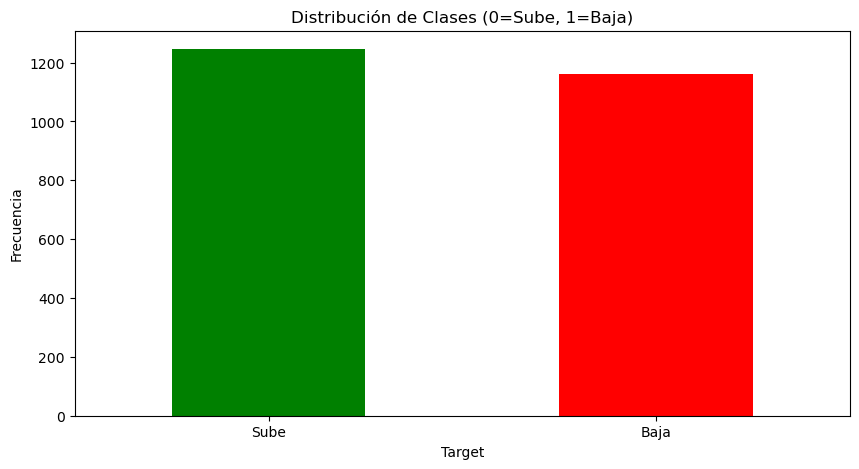

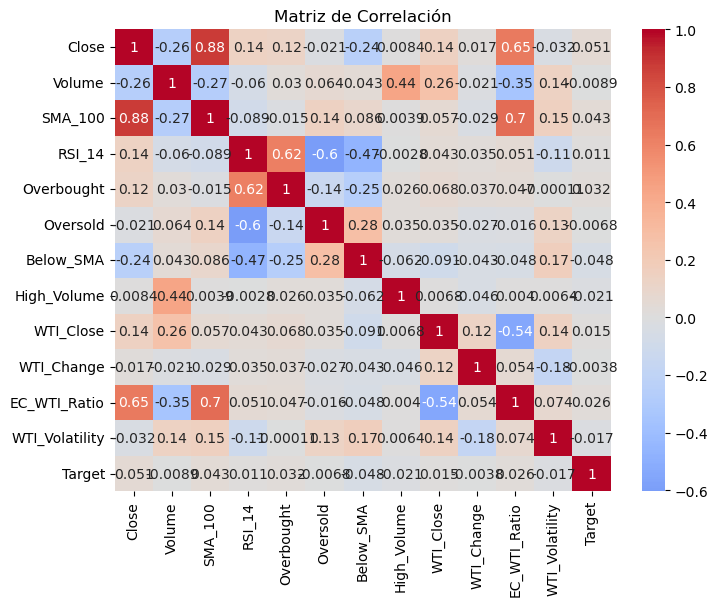

In [13]:
# --- 5. EDA ---
print("ANÁLISIS EXPLORATORIO DE DATOS (EDA)")

# Distribución del target

plt.figure(figsize=(10,5))
df_ml['Target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de Clases (0=Sube, 1=Baja)')
plt.xticks([0,1], ['Sube', 'Baja'], rotation=0)
plt.ylabel('Frecuencia')
plt.show()

# Correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_ml[features + ['Target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [14]:
#DIVISIÓN TRAIN/TEST ---
X = df_ml[features]
y = df_ml['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # ¡Importante: serie temporal!
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}\n")

Train: 1925 | Test: 482



In [15]:
#BASELINE MODEL ---
baseline_acc = max(y_test.value_counts()) / len(y_test)
print(f"Baseline (predicción mayoritaria): {baseline_acc:.3f}\n")

Baseline (predicción mayoritaria): 0.527



In [16]:
#ENTRENAR MÚLTIPLES MODELOS ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")

Logistic Regression: 0.527
Random Forest: 0.523
KNN: 0.529
XGBoost: 0.500


/opt/anaconda3/envs/midterm-model/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:11:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [17]:
#ENTRENAR Y COMPARAR 4 MODELOS ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")

#MEJOR MODELO ---
best_name = max(results, key=results.get)
best_model = models[best_name]
print(f"\nMEJOR MODELO: {best_name} → {results[best_name]:.3f}")

Logistic Regression: 0.527
Random Forest: 0.523
KNN: 0.529
XGBoost: 0.500

MEJOR MODELO: KNN → 0.529


/opt/anaconda3/envs/midterm-model/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:11:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

        Sube       0.55      0.60      0.57       254
        Baja       0.50      0.45      0.48       228

    accuracy                           0.53       482
   macro avg       0.53      0.53      0.52       482
weighted avg       0.53      0.53      0.53       482



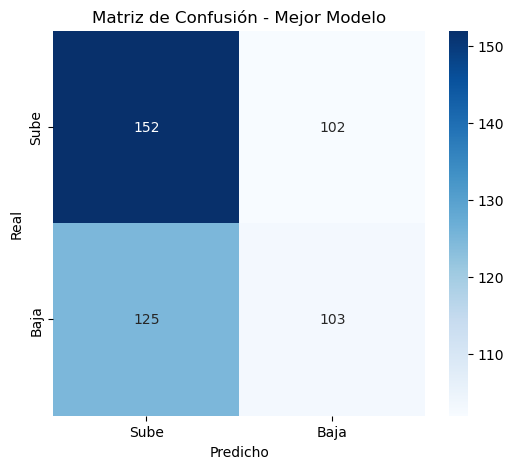

In [18]:
#EVALUACIÓN DETALLADA
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Sube', 'Baja']))

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sube', 'Baja'], yticklabels=['Sube', 'Baja'])
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [19]:
#GUARDAR MODELO
os.makedirs('data', exist_ok=True)
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(features, 'data/features.pkl')
print("\nModelo guardado como 'best_model.pkl'")


Modelo guardado como 'best_model.pkl'


In [20]:
#EXPORTAR DATOS
df_ml.to_csv('data/EC_processed.csv', index=True)
print("Datos procesados guardados en 'data/EC_processed.csv'")

Datos procesados guardados en 'data/EC_processed.csv'


In [21]:
print("Columnas en df original:", df.columns.tolist())
print("Columnas en df_ml:", df_ml.columns.tolist())
print("Filas en df_ml después de dropna:", len(df_ml.dropna()))

Columnas en df original: ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume', 'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility', 'Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'Tomorrow_Close', 'Target']
Columnas en df_ml: ['Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility', 'Target']
Filas en df_ml después de dropna: 2407


In [22]:
#VER DISTRIBUCIÓN DE CLASES
print("Distribución en TEST:")
print(y_test.value_counts(normalize=True).round(3))

#RESULTADOS DE TUS MODELOS
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.3f}")

Distribución en TEST:
Target
0    0.527
1    0.473
Name: proportion, dtype: float64
Logistic Regression: 0.527
Random Forest: 0.523
KNN: 0.529
XGBoost: 0.500


/opt/anaconda3/envs/midterm-model/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:11:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
# GUARDAR LOS DATOS PARA EL CONTENEDOR
df_ml.to_csv('data/df_ml.csv', index=False)
print("Datos guardados en data/df_ml.csv")

Datos guardados en data/df_ml.csv


In [24]:
# PRUEBA DE COMPROBACION DE LISTA DE FEATURES
import joblib
features = joblib.load('data/features.pkl')
print(features)

['Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility']


In [25]:
import sklearn
import joblib
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)

scikit-learn: 1.0.1
joblib: 1.5.1


In [26]:
import joblib
import os

# Crear carpeta
os.makedirs('data', exist_ok=True)

# Guardar features
joblib.dump(features, 'data/features.pkl')
print("features.pkl guardado en data/")

features.pkl guardado en data/
